# Data Augmentation using SpecAugment

In this notebook I am going to check how to imlement data augmentation using `SpecAugment` which first was introduced in <a href="https://arxiv.org/pdf/1904.08779.pdf">this papaer</a>.

First I wiil check it on english dataset and then use it in persian dataset.

In [ ]:
!pip install librosa
!pip install SpecAugment
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import librosa
import librosa.display
import tensorflow as tf
from tensorflow_addons.image import sparse_image_warp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def warp(spec, aug_param=80):
  fbank_size = tf.shape(spec)
  n, v = fbank_size[1], fbank_size[2]

  pt = tf.random.uniform([], aug_param, n-aug_param, tf.int32)
  src_ctr_pt_freq = tf.range(v // 2)
  src_ctr_pt_time = tf.ones_like(src_ctr_pt_freq) * pt
  src_ctr_pts = tf.stack((src_ctr_pt_time, src_ctr_pt_freq), -1)
  src_ctr_pts = tf.cast(src_ctr_pts, dtype=tf.float32)

  w = tf.random.uniform([], -aug_param, aug_param, tf.int32)
  dest_ctr_pt_freq = src_ctr_pt_freq
  dest_ctr_pt_time = src_ctr_pt_time + w
  dest_ctr_pts = tf.stack((dest_ctr_pt_time, dest_ctr_pt_freq), -1)
  dest_ctr_pts = tf.cast(dest_ctr_pts, dtype=tf.float32)

  source_control_point_locations = tf.expand_dims(src_ctr_pts, 0)
  dest_control_point_locations = tf.expand_dims(dest_ctr_pts, 0)

  warped_image, _ = sparse_image_warp(spec,
                                      source_control_point_locations,
                                      dest_control_point_locations)
  return warped_image

In [ ]:
def frequency_masking(spec, v, freq_param=27, mask_num=2):
    fbank_size = tf.shape(spec)
    n, v = fbank_size[1], fbank_size[2]

    for i in range(mask_num):
        f = tf.random.uniform([], minval=0, maxval=freq_param, dtype=tf.int32)
        v = tf.cast(v, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval=v-f, dtype=tf.int32)

        mask = tf.concat((tf.ones(shape=(1, n, v - f0 - f, 1)),
                          tf.zeros(shape=(1, n, f, 1)),
                          tf.ones(shape=(1, n, f0, 1)),
                          ), 2)
        spec = spec * mask
    return tf.cast(spec, dtype=tf.float32)

In [ ]:
def time_masking(spec, tau, time_param=100, mask_num=2):
    fbank_size = tf.shape(spec)
    n, v = fbank_size[1], fbank_size[2]

    for i in range(mask_num):
        t = tf.random.uniform([], minval=0, maxval=time_param, dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval=tau-t, dtype=tf.int32)

        mask = tf.concat((tf.ones(shape=(1, n-t0-t, v, 1)),
                          tf.zeros(shape=(1, t, v, 1)),
                          tf.ones(shape=(1, t0, v, 1)),
                          ), 1)
        spec = spec * mask
    return tf.cast(spec, dtype=tf.float32)

In [ ]:
def spec_augment(spec):
    v = spec.shape[0]
    tau = spec.shape[1]

    warped_spec = warp(spec)

    warped_frequency_spec = frequency_masking(warped_spec, v=v)

    warped_frequency_time_sepctrogram = time_masking(warped_frequency_spec, tau=tau)

    return warped_frequency_time_sepctrogram

In [ ]:
def visualization_spectrogram(spec, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spec[0, :, :, 0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def visualization_tensor_spectrogram(spec, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spec[0, :, :, 0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
import argparse
import librosa
import os, sys
import numpy as np

In [ ]:
audio_path = '/content/data_61-70968-0002.wav'
time_warping_param = 80
time_masking_param = 180
frequency_masking_param = 27
masking_line_number = 1

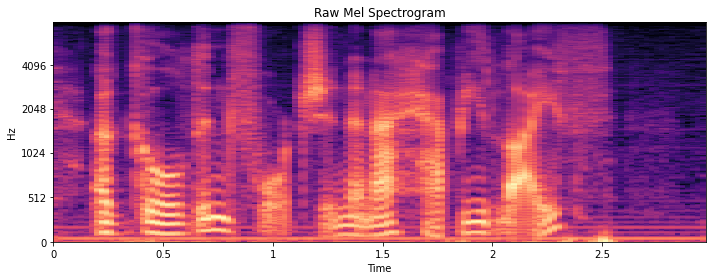

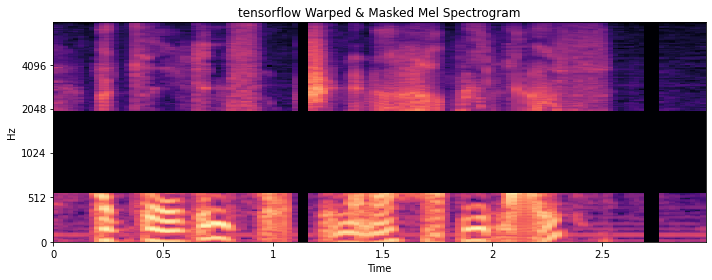

In [ ]:
audio, sampling_rate = librosa.load(audio_path)
spec = librosa.feature.melspectrogram(y=audio,
                                      sr=sampling_rate,
                                      n_mels=256,
                                      hop_length=512,
                                      fmax=8000)
    
shape = spec.shape
spec = np.reshape(spec, (-1, shape[0], shape[1], 1))

visualization_spectrogram(spec=spec,
                          title="Raw Mel Spectrogram")
augmented_spec = spec_augment(spec)
visualization_tensor_spectrogram(spec=augmented_spec,
                                 title="tensorflow Warped & Masked Mel Spectrogram")

In [ ]:
augmented_spec = np.reshape(augmented_spec, (256, 128))

In [ ]:
import soundfile
import librosa
import librosa.display
import numpy as np

S = librosa.feature.inverse.mel_to_stft(augmented_spec, sr=sampling_rate, fmax=8000)
y = librosa.griffinlim(S)

soundfile.write('/content/orig.wav', y, samplerate=sampling_rate)

In [ ]:
soundfile.write('/content/orig.wav', y, samplerate=sampling_rate)

In [ ]:
a.shape

(256, 512)

In [ ]:
audio, sampling_rate = librosa.load(audio_path)
spec = librosa.feature.melspectrogram(y=audio,
                                      sr=sampling_rate,
                                      n_mels=256,
                                      hop_length=128,
                                      fmax=8000)

S = librosa.feature.inverse.mel_to_stft(spec, sr=sampling_rate, fmax=8000)
y = librosa.griffinlim(S)

soundfile.write('/content/orig.wav', y, samplerate=sampling_rate)